Loaded: /Users/KrisLiu/Downloads/patient_features_final.csv | shape=(16369, 69)
---- Threshold derivation (80th percentile) ----
p80_raw = 34.0000 | floor=34 | ceil=34
positives @floor  >= 34: 3388 (20.698%)
positives @ceil   >= 34 : 3388  (20.698%)
Chosen integer threshold = 34
Label prevalence (>= 34 encounters): 20.698%


/Users/KrisLiu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/KrisLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/KrisLiu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LogReg] AUROC=0.947 | AUPRC=0.856 | ACC@0.5=0.885 | F1@0.5=0.757 | best_thr=0.632 F1=0.781
[LogReg] CM@0.5: TN=2307 FP=289 FN=89 TP=589


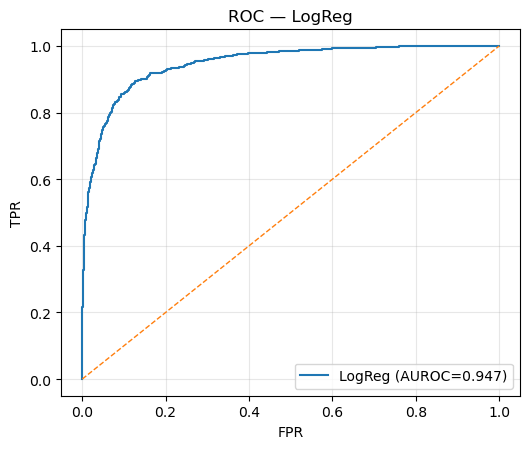

Saved: /Users/KrisLiu/Downloads/model_out/roc_LogReg.png


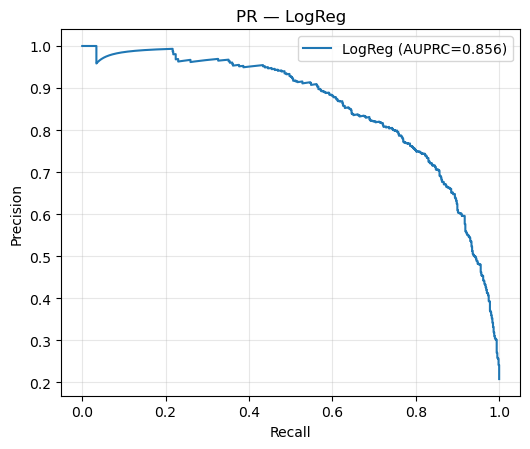

Saved: /Users/KrisLiu/Downloads/model_out/pr_LogReg.png
[RandForest] AUROC=0.967 | AUPRC=0.898 | ACC@0.5=0.922 | F1@0.5=0.796 | best_thr=0.430 F1=0.811
[RandForest] CM@0.5: TN=2515 FP=81 FN=176 TP=502


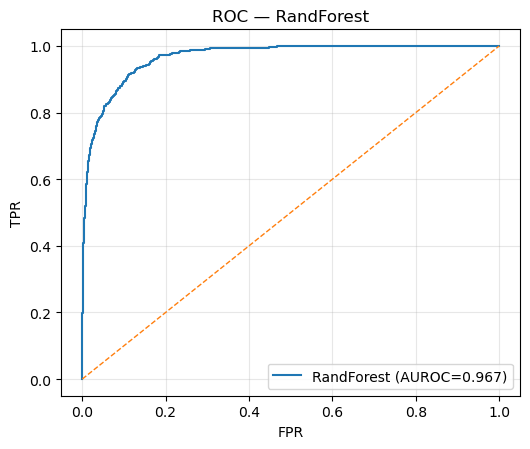

Saved: /Users/KrisLiu/Downloads/model_out/roc_RandForest.png


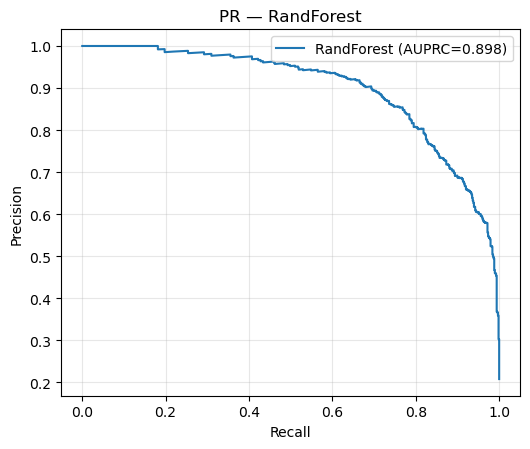

Saved: /Users/KrisLiu/Downloads/model_out/pr_RandForest.png
Saved: /Users/KrisLiu/Downloads/model_out/metrics_summary.csv


In [10]:
# ====== High-utilization baseline from n_encounters (local paths)
import os  # paths
import numpy as np  # arrays
import pandas as pd  # dataframes
import matplotlib.pyplot as plt  # plots

from sklearn.model_selection import train_test_split  # split
from sklearn.compose import ColumnTransformer  # preprocess
from sklearn.pipeline import Pipeline  # pipeline
from sklearn.preprocessing import OneHotEncoder  # OHE
from sklearn.impute import SimpleImputer  # missing values
from sklearn.linear_model import LogisticRegression  # model A
from sklearn.ensemble import RandomForestClassifier  # model B
from sklearn.metrics import (  # metrics
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    precision_recall_curve, roc_curve, confusion_matrix
)

# ---------- 0) Local paths ----------
DATA_PATH = os.path.expanduser("/Users/KrisLiu/Downloads/patient_features_final.csv")  # input csv path
OUT_DIR   = os.path.expanduser("/Users/KrisLiu/Downloads/model_out")  # output folder
os.makedirs(OUT_DIR, exist_ok=True)  # ensure folder
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"  # verify

df = pd.read_csv(DATA_PATH)  # read data
print(f"Loaded: {DATA_PATH} | shape={df.shape}")  # status

# ---------- 1) Derive integer threshold from 80th percentile ----------
p80_raw = df["n_encounters"].quantile(0.80)  # 80th percentile (float)
p80_floor = int(np.floor(p80_raw))  # floor to integer
p80_ceil  = int(np.ceil(p80_raw))   # ceil to integer

# choose integer threshold: exact integer if p80_raw is integer, else use ceil (conservative)
if abs(p80_raw - round(p80_raw)) < 1e-9:  # already an integer
    THR_INT = int(round(p80_raw))  # integer threshold
else:
    THR_INT = p80_ceil  # use ceil when non-integer

# show counts at floor/ceil for transparency  # English
n = len(df)  # total rows
pos_floor = int((df["n_encounters"] >= p80_floor).sum())  # positives if floor
pos_ceil  = int((df["n_encounters"] >= p80_ceil).sum())   # positives if ceil

print("---- Threshold derivation (80th percentile) ----")  # log
print(f"p80_raw = {p80_raw:.4f} | floor={p80_floor} | ceil={p80_ceil}")  # log
print(f"positives @floor  >= {p80_floor}: {pos_floor} ({pos_floor/n:.3%})")  # log
print(f"positives @ceil   >= {p80_ceil} : {pos_ceil}  ({pos_ceil/n:.3%})")  # log
print(f"Chosen integer threshold = {THR_INT}")  # final choice

# ---------- 2) Build binary label ----------
df["label_high_util"] = (df["n_encounters"] >= THR_INT).astype(int)  # target label
prevalence = df["label_high_util"].mean()  # base rate
print(f"Label prevalence (>= {THR_INT} encounters): {prevalence:.3%}")  # log

# ---------- 3) Feature matrix (drop leakage/IDs/free-text) ----------
drop_cols = ["patient_id", "n_encounters", "icd10_codes_array", "procedure_list", "PATIENT_BIRTH_YEAR"]  # avoid leakage
feature_cols = [c for c in df.columns if c not in drop_cols + ["label_high_util"]]  # features
X = df[feature_cols].copy()  # X matrix
y = df["label_high_util"].values  # y vector

cat_cols = [c for c in feature_cols if X[c].dtype == "object"]  # categorical
num_cols = [c for c in feature_cols if c not in cat_cols]  # numeric

# ---------- 4) Preprocess ----------
num_tf = Pipeline([("imp", SimpleImputer(strategy="median"))])  # numeric imputation
cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),  # categorical imputation
                   ("oh", OneHotEncoder(handle_unknown="ignore", sparse=True))])  # one-hot
preprocess = ColumnTransformer([("num", num_tf, num_cols), ("cat", cat_tf, cat_cols)])  # column transformer

# ---------- 5) Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)  # stratified 80/20 split

# ---------- 6) Models ----------
lr = Pipeline([("prep", preprocess),
               ("clf", LogisticRegression(solver="saga", penalty="l2",
                                          class_weight="balanced", max_iter=1000, n_jobs=-1, random_state=42))])  # logistic
rf = Pipeline([("prep", preprocess),
               ("clf", RandomForestClassifier(n_estimators=400, min_samples_leaf=2,
                                             class_weight="balanced_subsample", n_jobs=-1, random_state=42))])  # random forest

lr.fit(X_train, y_train)  # train LR
rf.fit(X_train, y_train)  # train RF

# ---------- 7) Eval helper ----------
def evaluate_and_plot(model, name):
    clf = model.named_steps[list(model.named_steps.keys())[-1]]  # final estimator
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else model.decision_function(X_test)  # proba
    y_pred = (y_prob >= 0.5).astype(int)  # default 0.5
    auroc = roc_auc_score(y_test, y_prob)  # AUROC
    auprc = average_precision_score(y_test, y_prob)  # AUPRC
    acc = accuracy_score(y_test, y_pred)  # ACC
    f1 = f1_score(y_test, y_pred)  # F1
    prec, rec, thrs = precision_recall_curve(y_test, y_prob)  # PR arrays
    f1s = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-12)  # F1 per threshold
    best_ix = int(np.nanargmax(f1s))  # index
    best_thr, best_f1 = float(thrs[best_ix]), float(f1s[best_ix])  # best threshold/f1
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # confusion at 0.5
    print(f"[{name}] AUROC={auroc:.3f} | AUPRC={auprc:.3f} | ACC@0.5={acc:.3f} | F1@0.5={f1:.3f} | best_thr={best_thr:.3f} F1={best_f1:.3f}")  # summary
    print(f"[{name}] CM@0.5: TN={tn} FP={fp} FN={fn} TP={tp}")  # confusion

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # roc arrays
    plt.figure(figsize=(5.4,4.6))  # fig
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auroc:.3f})")  # line
    plt.plot([0,1],[0,1],"--", lw=1)  # diag
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {name}"); plt.legend(); plt.grid(True, alpha=0.3)  # labels
    roc_path = os.path.join(OUT_DIR, f"roc_{name}.png")  # path
    plt.tight_layout(); plt.savefig(roc_path, dpi=150); plt.show()  # save+show
    print("Saved:", roc_path)  # log

    # PR
    plt.figure(figsize=(5.4,4.6))  # fig
    plt.plot(rec, prec, label=f"{name} (AUPRC={auprc:.3f})")  # line
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — {name}"); plt.legend(); plt.grid(True, alpha=0.3)  # labels
    pr_path = os.path.join(OUT_DIR, f"pr_{name}.png")  # path
    plt.tight_layout(); plt.savefig(pr_path, dpi=150); plt.show()  # save+show
    print("Saved:", pr_path)  # log

    return dict(model=name, AUROC=auroc, AUPRC=auprc, ACC_0p5=acc, F1_0p5=f1, best_thr=best_thr, best_F1=best_f1)  # return

# ---------- 8) Evaluate & save ----------
m_lr = evaluate_and_plot(lr, "LogReg")  # evaluate LR
m_rf = evaluate_and_plot(rf, "RandForest")  # evaluate RF

pd.DataFrame([m_lr, m_rf]).to_csv(os.path.join(OUT_DIR, "metrics_summary.csv"), index=False)  # save metrics
print("Saved:", os.path.join(OUT_DIR, "metrics_summary.csv"))  # log

